# Molecular dynamics application example

Go to:
    
  - [Notebook configuration](md_example.ipynb#Notebook-configuration)
  - [Helper functions](md_example.ipynb#Helper-functions)
  - [The C-type lectin receptor langerin](md_example.ipynb#The-C-type-lection-receptor-langerin)
  - [Preliminary checks](md_example.ipynb#Preliminary-checks)
  - [Clustering root data](md_example.ipynb#Clustering-root-data)
  - [Semi-automatic hierarchical clustering](md_example.ipynb#Semi-automatic-hierarchical-clustering)
  - [Automatic hierarchical clustering](md_example.ipynb#Automatic-hierarchical-clustering)

## Notebook configuration

In [1]:
import sys

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sklearn
from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm

import commonnn
from commonnn import cluster, plot, recipes, _types, _fit, _bundle

Print Python and package version information:

In [2]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, sklearn, commonnn]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:57:39)  [GCC 9.3.0]
Packages:
    matplotlib: 3.9.4
    numpy: 1.26.4
    sklearn: 1.6.1
    commonnn: 0.0.4


We use [Matplotlib](https://matplotlib.org/) to create plots. The `matplotlibrc` file in the root directory of the `CommonNNClustering` repository is used to customize the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

## Helper functions

In [5]:
def draw_evaluate(clustering, axis_labels=False, plot_style="dots"):
    
    fig, Ax = plt.subplots(
        1, 3,
        figsize=(
            mpl.rcParams['figure.figsize'][0],
            mpl.rcParams['figure.figsize'][1] * 0.5)
        )

    for dim in range(3):
        dim_ = (dim * 2, dim * 2 + 1)
        
        ax_props_ = {**ax_props}
        if axis_labels:
            ax_props_.update(
                {"xlabel": dim_[0] + 1, "ylabel": dim_[1] + 1}
            )

        _ = clustering.evaluate(
            ax=Ax[dim],
            plot_style=plot_style,
            ax_props=ax_props_,
            dim=dim_
            )
        
        Ax[dim].yaxis.get_label().set_rotation(0)

## The C-type lectin receptor langerin

Let's read in some "real world" data for this example. We will work with a 6D projection from a classical MD trajectory of the C-type lectin receptor langerin that was generated by the dimension reduction procedure TICA.

In [6]:
langerin = cluster.Clustering(
    np.load("md_example/langerin_projection.npy", allow_pickle=True),
    alias="C-type lectin langerin"
    )

After creating a `Clustering` instance, we can print out basic information about the data. The projection comes in 116 parts of individual independent simulations. In total we have about 26,000 data points in this set representing 26 microseconds of simulation time at a sampling timestep of 1 nanoseconds.

In [57]:
print(langerin.root.info())

alias: 'root'
hierarchy_level: 0
access: components
points: 26528
children: 0


In [58]:
print(langerin.root._input_data.meta)

{'access_components': True, 'edges': [56, 42, 209, 1000, 142, 251, 251, 251, 251, 251, 251, 251, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 144, 636, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]}


Dealing with six data dimensions we can still visualise the data quite well.

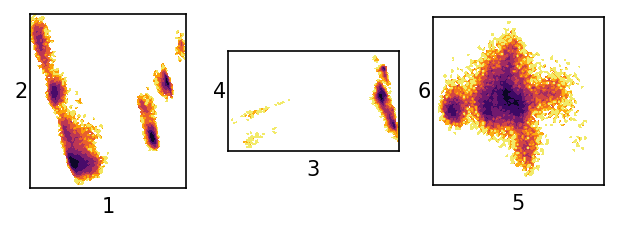

In [59]:
draw_evaluate(langerin, axis_labels=True, plot_style="contourf")

After a few preliminary checks, we will partition that data by 1-step threshold-based clustering and then also by using a semi-automatic and an automatic hierarchical clustering approach for comparison.

## Preliminary checks

So let's begin. A quick look on the distribution of distances in the set gives us a first feeling for what might be a suitable value for the neighbour search radius *r*.

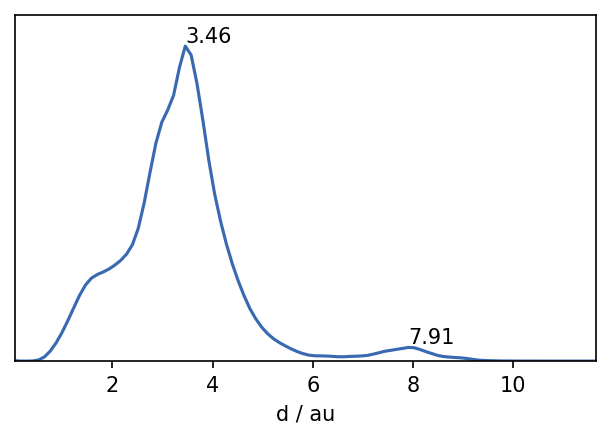

In [60]:
# Keep only upper triangle of the distance matrix to deduplicate
distances = pairwise_distances(
    langerin.input_data
)[np.triu_indices(langerin.root._input_data.n_points)].flatten().astype(np.float32)

fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances, maxima=True, maxima_props={"order": 5})

In [61]:
# Free memory
%xdel distances

We can suspect that values of *r* of roughly 2 or lower should be a good starting point. The maximum in the distribution closest to 0 defines a reasonable value range for $r$. We can also get a feeling for what values $n_\mathrm{c}$ could take on by checking the number of neighbours each point has for a given search radius.

In [62]:
# Can take a couple of minutes...
min_n = []
max_n = []
mean_n = []


tree = KDTree(langerin.input_data)
r_list = np.arange(0.25, 3.25, 0.25)
for r in tqdm(r_list):
    n_neighbours = [
        x.shape[0]
        for x in tree.query_radius(
            langerin.input_data, r, return_distance=False
        )
    ]
    
    if r == 2.0:
        n_neighbours_highlight = np.copy(n_neighbours)
    
    min_n.append(np.min(n_neighbours))
    max_n.append(np.max(n_neighbours))
    mean_n.append(np.mean(n_neighbours))

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

[(0.25, 3.0), Text(0.5, 0, '$r$'), Text(0, 0.5, '#neighbours')]

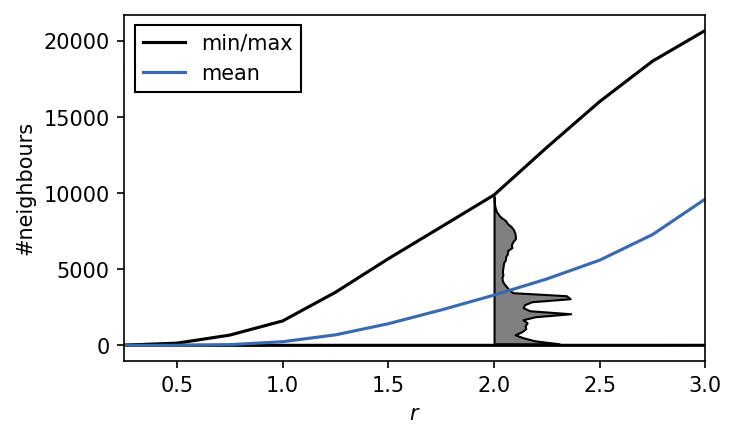

In [ ]:
h, e = np.histogram(n_neighbours_highlight, bins=50, density=True)
e = (e[:-1] + e[1:]) / 2

fig, ax = plt.subplots()
# ax.plot([2.0, 2.0], (e[0], e[-1]), "k")
ax.fill_betweenx(
    e, np.full_like(e, 2.0), 2.0 + h * 1000,
    edgecolor="k", facecolor="gray"
)
min_line, = ax.plot(r_list, min_n, "k")
max_line, = ax.plot(r_list, max_n, "k")
mean_line, = ax.plot(r_list, mean_n)

ax.legend(
    [min_line, mean_line], ["min/max", "mean"],
    fancybox=False, framealpha=1, edgecolor="k"
)

ax.set(**{
    "xlim": (r_list[0], r_list[-1]),
    "xlabel": "$r$",
    "ylabel": "#neighbours",
})

In the radius value regime of 2 and higher the number of neighbours per point quickly approaches the number of points in the whole data set. We can interpret these plots as upper bounds (max: hard bound; mean: soft bound) for $n_\mathrm{c}$ if $r$ varies. Values of $n_\mathrm{c}$ much larger than say 5000 probably wont make to much sense for radii below around 2.0. If the radius cutoff is set to $r=1$, $n_\mathrm{c}$ is already capped at a few hundreds. We can also see that for a radius of 2.0, a substantial amount of the data points have only very few neighbours. Care has to be taken that we do not loose an interesting portion of the feature space here when this radius is used. 

## Clustering root data

Let's attempt a first clustering step with a relatively low density criterion (large *r* cutoff, low number of common neighbours $n_\mathrm{c}$). When we cluster, we can judge the outcome by how many clusters we obtain and how many points end up as being classified as noise. For the first clustering steps, it can be a good idea to start with a low density cutoff and then increase it gradually (preferably by keeping $r$ constant and increasing $n_\mathrm{c}$). As we choose higher density criteria the number of resulting clusters will rise and so will the noise level. We need to find the point where we yield a large number of (reasonably sized) clusters without loosing relevant information in the noise regions. Keep in mind that the ideal number of clusters and noise ratio are not definable and highly dependent on the nature of the data and your (subjective) expectation if there is no dedicated way of clustering validation. 

In [ ]:
# Use a fast clustering recipe here
r = 1.5
neighbourhoods, sort_order, revert_order = recipes.sorted_neighbourhoods_from_coordinates(langerin.input_data, r=r, sort_by="both")
langerin_neighbourhoods = cluster.Clustering(
    neighbourhoods, recipe="sorted_neighbourhoods"
)

In [ ]:
langerin_neighbourhoods.fit(radius_cutoff=r, similarity_cutoff=2, member_cutoff=10)
langerin.labels = langerin_neighbourhoods.labels[revert_order]

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
26528     1.500     2         10        None      11        0.702     0.005     00:00:0.311
-----------------------------------------------------------------------------------------------



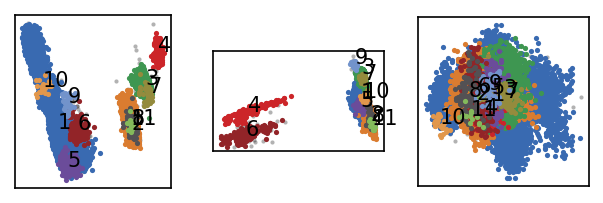

In [ ]:
draw_evaluate(langerin)

We obtain a low number of noise points and a handful of clusters so we are at least not completely of track here with our initial guess on $r$. To get a better feeling for how the clustering changes with higher density-thresholds, one could scan a few more parameter combinations.

In [ ]:
for c in tqdm(np.arange(0, 105, 1)):
    langerin_neighbourhoods.fit(radius_cutoff=r, similarity_cutoff=c, member_cutoff=10, v=False)
langerin.root._summary = langerin_neighbourhoods.root._summary

  0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
df = langerin.summary.to_DataFrame()
df[:10]

,n_points,radius_cutoff,similarity_cutoff,member_cutoff,max_clusters,n_clusters,ratio_largest,ratio_noise,execution_time
0,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.482993
1,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.442934
2,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.465871
3,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.348964
4,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.341427
5,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.339944
6,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.34093
7,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.340496
8,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.341145
9,26528,1.5,2,10,<NA>,11,0.702201,0.005428,0.340906


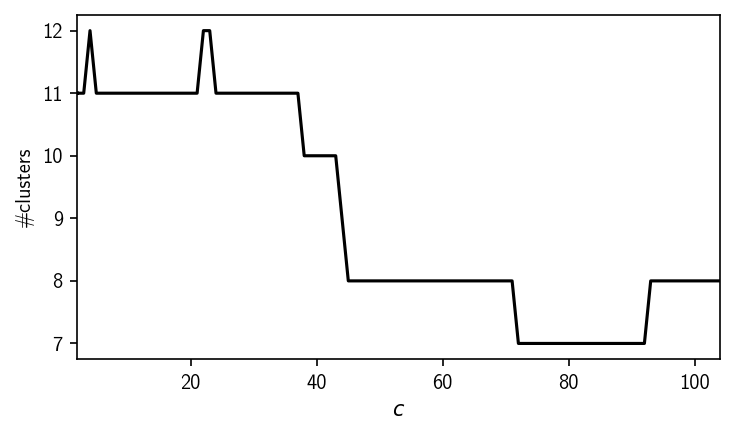

In [ ]:
c_values = df["similarity_cutoff"].to_numpy()
n_cluster_values = df["n_clusters"].to_numpy()

fig, ax = plt.subplots()
ax.plot(c_values, n_cluster_values, "k")
ax.set(**{
    "xlim": (c_values[0], c_values[-1]),
    "xlabel": "$c$",
    "ylabel": "#clusters",
    "yticks": range(np.min(n_cluster_values), np.max(n_cluster_values) + 1)
    })
fig.tight_layout()

As we see here, increasing $n_\mathrm{c}$ and therefore the density-threshold only yields less clusters which potentially means we are starting to loose information. 
To be sure, we can also double check the result with a somewhat larger radius to exclude that we already lost potential clusters with our first parameter combination. 

In [ ]:
r = 2
neighbourhoods, sort_order, revert_order = recipes.sorted_neighbourhoods_from_coordinates(langerin.input_data, r=r, sort_by="both")
langerin_neighbourhoods = cluster.Clustering(
    neighbourhoods, recipe="sorted_neighbourhoods"
)

In [64]:
for c in tqdm(np.arange(0, 105, 1)):
    langerin_neighbourhoods.fit(radius_cutoff=r, similarity_cutoff=c, member_cutoff=10, v=False)
langerin.root._summary = langerin_neighbourhoods.root._summary

  0%|          | 0/105 [00:00<?, ?it/s]

[(0.0, 104.0),
 Text(0.5, 0, '$c$'),
 Text(0, 0.5, '#clusters'),

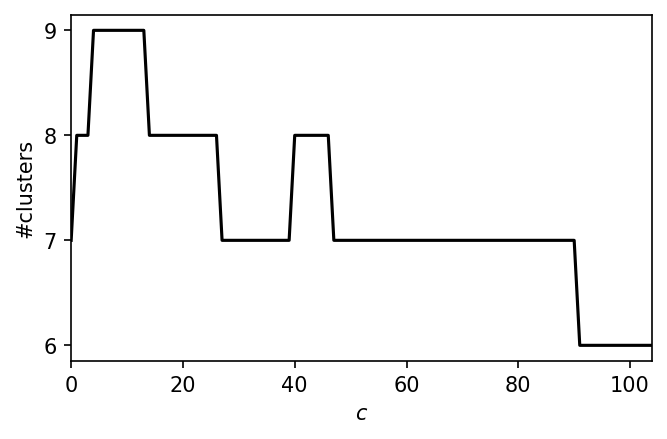

In [65]:
df = langerin.summary.to_DataFrame()

c_values = df["similarity_cutoff"].to_numpy()
n_cluster_values = df["n_clusters"].to_numpy()

fig, ax = plt.subplots()
ax.plot(c_values, n_cluster_values, "k")
ax.set(**{
    "xlim": (c_values[0], c_values[-1]),
    "xlabel": "$c$",
    "ylabel": "#clusters",
    "yticks": range(np.min(n_cluster_values), np.max(n_cluster_values) + 1)
    })

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
26528     2.000     1         10        None      8         0.962     0.001     00:00:0.691
-----------------------------------------------------------------------------------------------



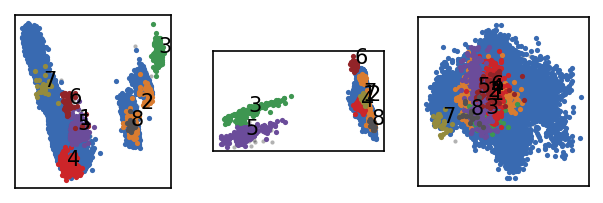

In [47]:
langerin_neighbourhoods.fit(radius_cutoff=r, similarity_cutoff=1, member_cutoff=10)
langerin.labels = langerin_neighbourhoods.labels[revert_order]
draw_evaluate(langerin)

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
26528     2.000     5         10        None      9         0.962     0.002     00:00:0.696
-----------------------------------------------------------------------------------------------



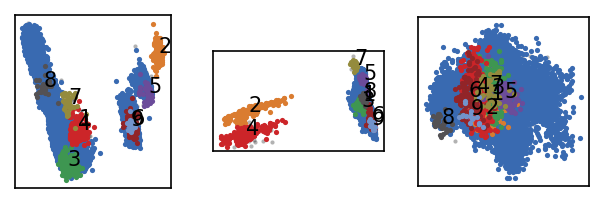

In [48]:
langerin_neighbourhoods.fit(radius_cutoff=r, similarity_cutoff=5, member_cutoff=10)
langerin.labels = langerin_neighbourhoods.labels[revert_order]
draw_evaluate(langerin)

It looks like we obtain no additional cluster with the larger radius that is lost for the smaller one. For now we can deliberately stick with the smaller radius.
We could now use manual hierarchical clustering to freeze the obtained clustering and increase the density-threshold only for a portion of the data set. Since this could become quite involved, though, we will not follow that route here and concentrate instead on the semi-automatic and automatic alternatives further below.

## Semi-automatic hierarchical clustering

We described rationally guided, manual hierarchical clustering in the [*Hierarchical clustering basics*](hierarchical_clustering_basics.ipynb) tutorial using the `isolate` formalism. Here we want to take the different approach of generating a cluster hierarchy more or less automatically for a given cluster parameter range. We will use the radius of $r=1.5$ from the last section and a grid of $n_\mathrm{c}$ values to cluster subsequently with higher density-thresholds while we keep track of the change in the cluster label assignments.

In [7]:
r = 1.5
neighbourhoods, sort_order, revert_order = recipes.sorted_neighbourhoods_from_coordinates(langerin.input_data, r=r, sort_by="both")
langerin_neighbourhoods = cluster.Clustering(
    neighbourhoods, recipe="sorted_neighbourhoods"
)

We will start at $n_\mathrm{c}=2$ but we will also need to determine a reasonable endpoint. To check the deduction of an upper bound from the number-of-neioghbours plot in the last section, let's have a look at a clustering with a very high density-threshold.

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
26528     1.500     950       None      None      4         0.314     0.430     00:00:3.710
-----------------------------------------------------------------------------------------------



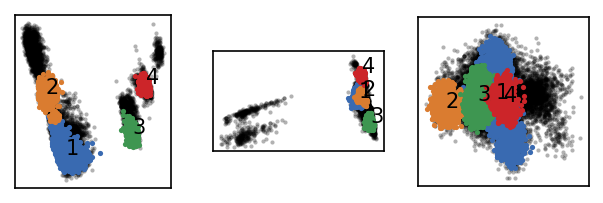

In [8]:
langerin_neighbourhoods.fit(radius_cutoff=r, similarity_cutoff=950)
langerin.labels = langerin_neighbourhoods.labels[revert_order]
draw_evaluate(langerin)

At this point, the clustering does yield only clusters that are shrinking with even higher values for $n_\mathrm{c}$. To perform a semi-automatic hierarchical clustering, we can use
the `HierarchicalFitter` class `HierarchicalFitterRepeat`. This type uses a fitter repeatedly to build a cluster hierarchy.

In [9]:
langerin_neighbourhoods._hierarchical_fitter = _fit.HierarchicalFitterRepeat(
    langerin_neighbourhoods.fitter
)

In [10]:
# Make a range of c values with larger jumps towards the end
c_range = [2]
for _ in range(108):
    x = c_range[-1]
    c_range.append(max(x + 1, int(x * 1.05)))
print(c_range)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 63, 66, 69, 72, 75, 78, 81, 85, 89, 93, 97, 101, 106, 111, 116, 121, 127, 133, 139, 145, 152, 159, 166, 174, 182, 191, 200, 210, 220, 231, 242, 254, 266, 279, 292, 306, 321, 337, 353, 370, 388, 407, 427, 448, 470, 493, 517, 542, 569, 597, 626, 657, 689, 723, 759, 796, 835, 876, 919, 964]


In [11]:
langerin_neighbourhoods.fit_hierarchical(
    radius_cutoffs=r,
    similarity_cutoffs=c_range,
    member_cutoff=10
)

2025-04-11 11:46:54.557 | INFO     | __main__:<module>:1 - Running step 0     (r = 1.5, c = 2)
2025-04-11 11:46:54.873 | INFO     | __main__:<module>:1 - Running step 1     (r = 1.5, c = 3)
2025-04-11 11:46:55.188 | INFO     | __main__:<module>:1 - Running step 2     (r = 1.5, c = 4)
2025-04-11 11:46:55.504 | INFO     | __main__:<module>:1 - Running step 3     (r = 1.5, c = 5)
2025-04-11 11:46:55.824 | INFO     | __main__:<module>:1 - Running step 4     (r = 1.5, c = 6)
2025-04-11 11:46:56.140 | INFO     | __main__:<module>:1 - Running step 5     (r = 1.5, c = 7)
2025-04-11 11:46:56.460 | INFO     | __main__:<module>:1 - Running step 6     (r = 1.5, c = 8)
2025-04-11 11:46:56.782 | INFO     | __main__:<module>:1 - Running step 7     (r = 1.5, c = 9)
2025-04-11 11:46:57.102 | INFO     | __main__:<module>:1 - Running step 8     (r = 1.5, c = 10)
2025-04-11 11:46:57.423 | INFO     | __main__:<module>:1 - Running step 9     (r = 1.5, c = 11)
2025-04-11 11:46:57.745 | INFO     | __main__:<m

The resulting hierarchy of clusterings can be visualised either as a tree or pie plot.

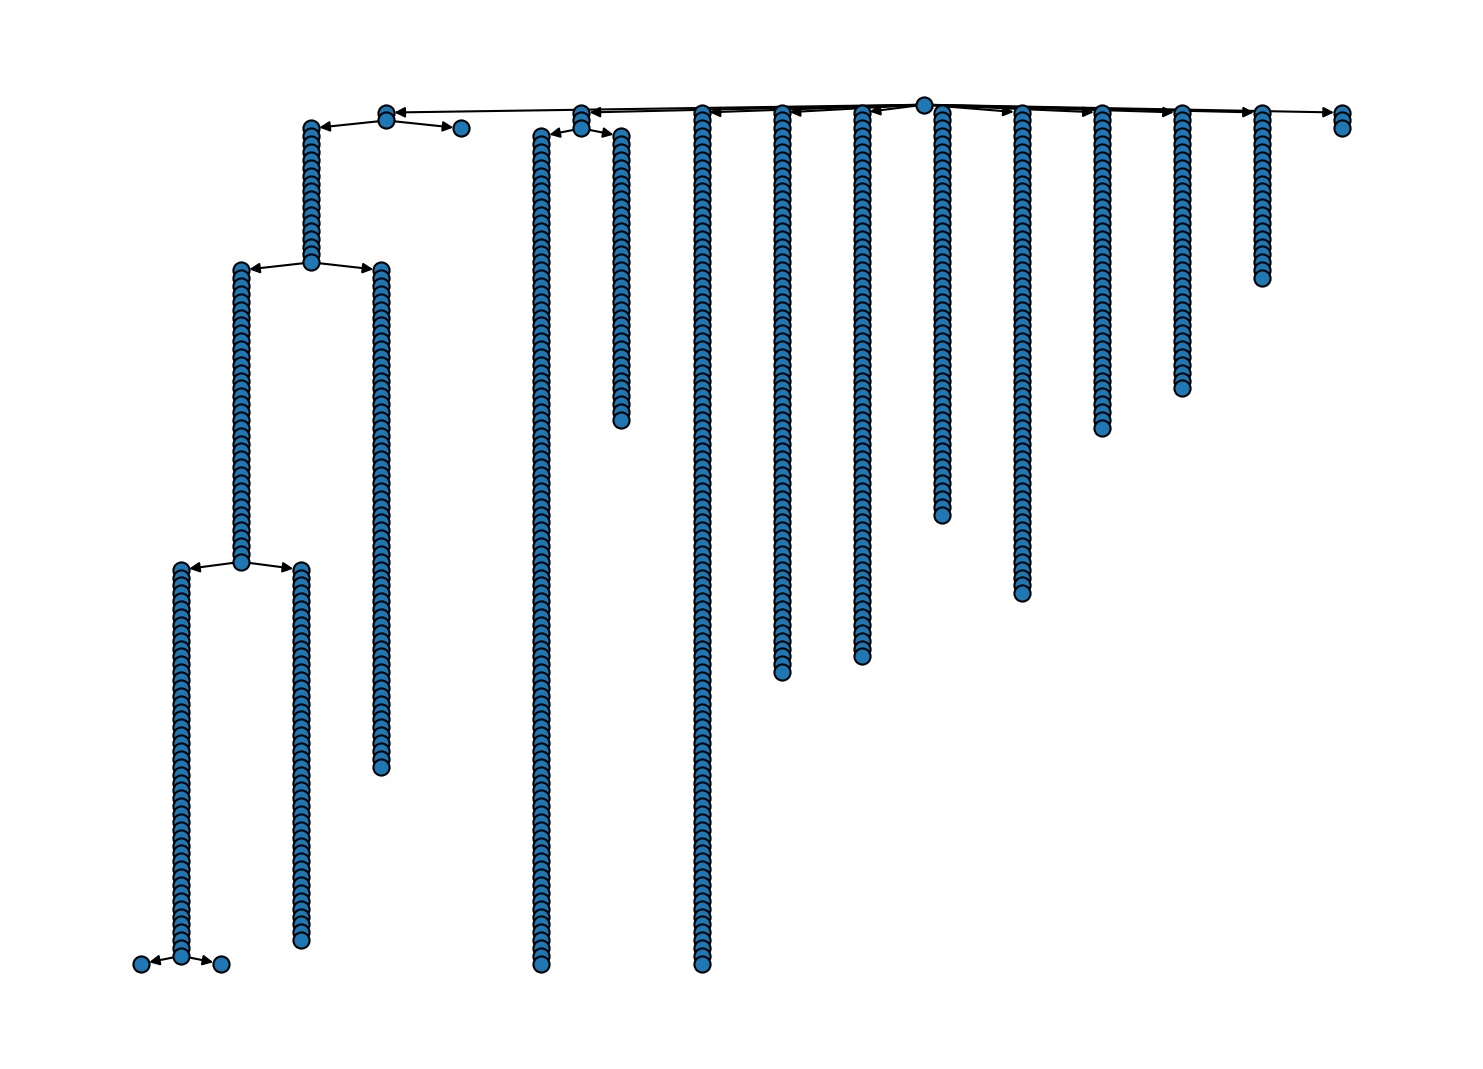

In [12]:
# Cluster hierarchy as tree diagram
#     (hierarchy level increasing from top to bottom)
fig, ax = plt.subplots(
    figsize=(
        mpl.rcParams["figure.figsize"][0] * 2.5,
        mpl.rcParams["figure.figsize"][1] * 3
    )
)
langerin_neighbourhoods.tree(
    ax=ax,
    draw_props={
        "node_size": 60,
        "node_shape": "o",
        "with_labels": False
    }
)

These diagrams can be admittedly hard to overlook because we have many hierarchy levels (one for each $n_\mathrm{c}$ grid point). To reduces the cluster hierarchy to only a relevant number of bundles, we can apply some sort of trimming. A trimming protocol can be anything that traverses the bundle hierarchy (starting with the root bundle) and decides which
bundles to keep, based on the bundle's properties. We provide currently four basic trimming protocols: `"trivial"`, `"shrinking"`, `"lonechild"`, and `"small"`. These can be triggered via `Clustering.trim()` under optional setting of the `protocol` keyword argument. Instead of a string
to refer to a provided protocol, it is also possible to pass a callable that receives a bundle as
the first argument and arbitrary keyword arguments.

The `"trivial"` protocol will remove the labels and all children on bundles that have all-zero cluster label assignments. The `"shrinking"` protocol removes the children on bundles that will never split again (only shrink). The `"lonechild"` protocol will replace a single child of a bundle with its grandchildren, and `"small"` removes bundles with less then `member_cutoff` members. Other protocols are conceivable and users are encouraged to implement their own.

Bundle processing is supported by the two generator functions `_bundle.bfs` and `_bundles.bfs_leafs` that allow to loop over bundles in a breadth-first-search fashion.

Let's see what execution of the `"trivial"` protocol does to our tree. In fact, it is purely cosemetic in the present case because noise points are not used to create new bundles during the used hierarchical fitting.

In [13]:
langerin_neighbourhoods['1.1.12'].labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
langerin_neighbourhoods['1.1.12'].children

{}

In [15]:
# Trim trivial nodes (has no effect here)
langerin_neighbourhoods.trim(langerin_neighbourhoods.root, protocol="trivial")

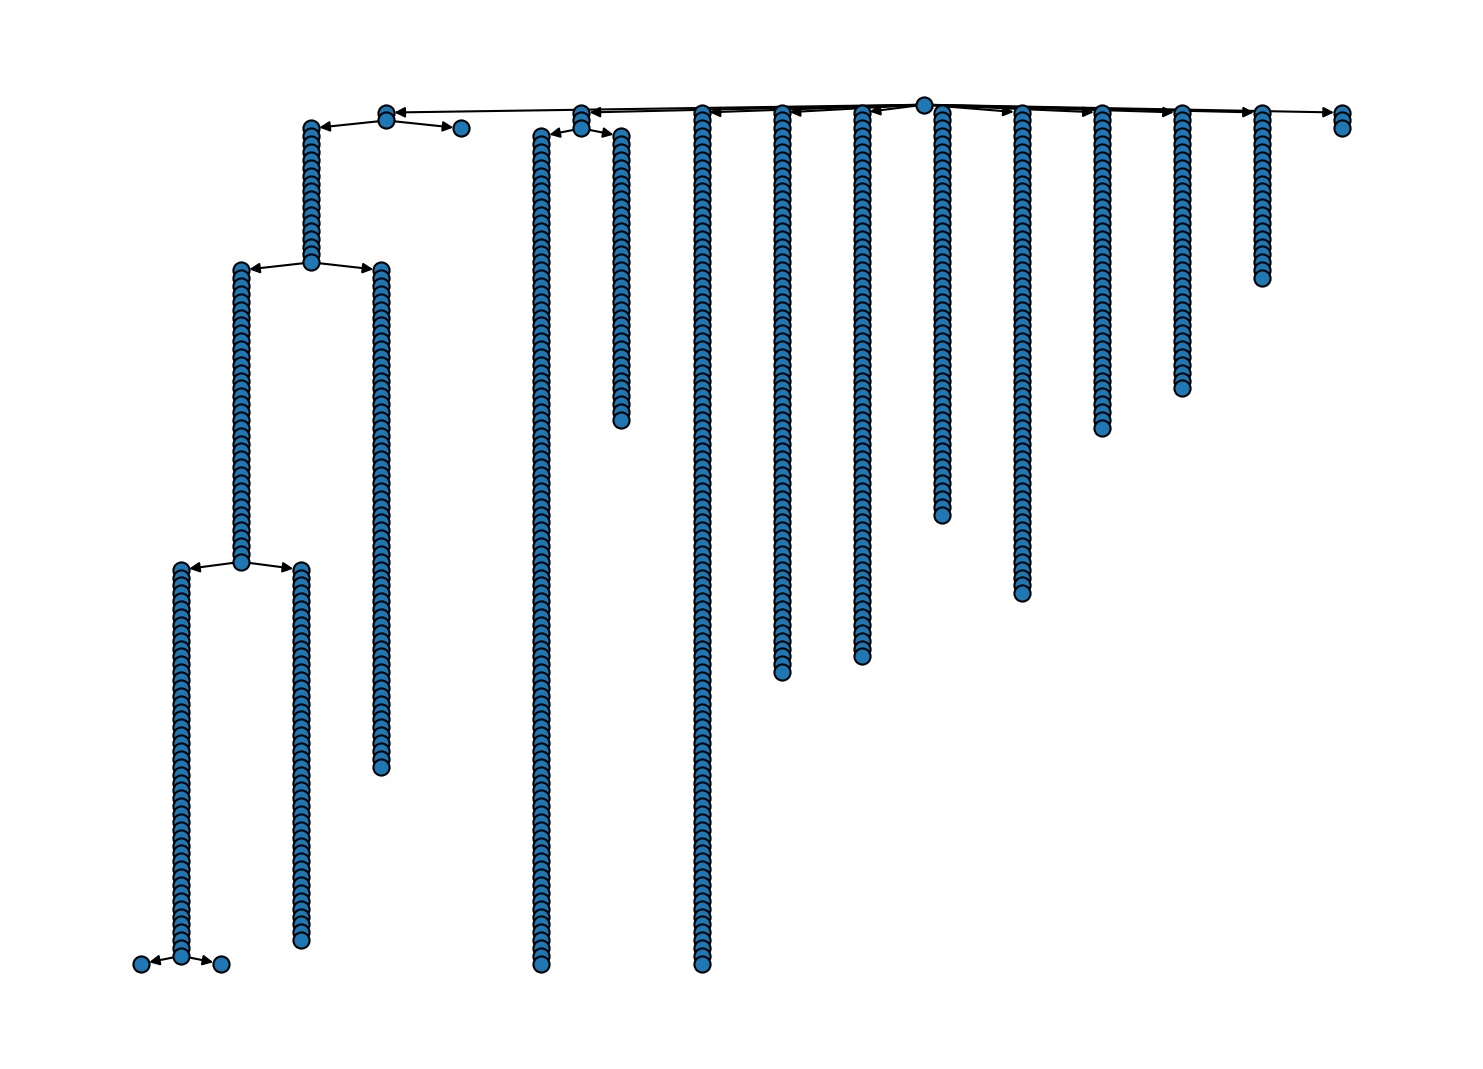

In [16]:
# Cluster hierarchy as tree diagram
#     (hierarchy level increasing from top to bottom)
fig, ax = plt.subplots(
    figsize=(
        mpl.rcParams["figure.figsize"][0] * 2.5,
        mpl.rcParams["figure.figsize"][1] * 3
    )
)
langerin_neighbourhoods.tree(
    ax=ax,
    draw_props={
        "node_size": 60,
        "node_shape": "o",
        "with_labels": False
    }
)

In [17]:
langerin_neighbourhoods['1.1.12'].labels

In [18]:
langerin_neighbourhoods['1.1.12'].children

{}

The `"shrinking"` protocol on the other hand has a major effect. Of all the bundles in the tree above, we will keep only those that emerge from an immediate split into sub-clusters. Bundles created as the sole child of a parent will be removed if there is no further split further down the line. Note that this will still keep lone children if there is an actual split downstream.

In [19]:
# The "shrinking" protocol is the default
langerin_neighbourhoods.trim(langerin_neighbourhoods.root)

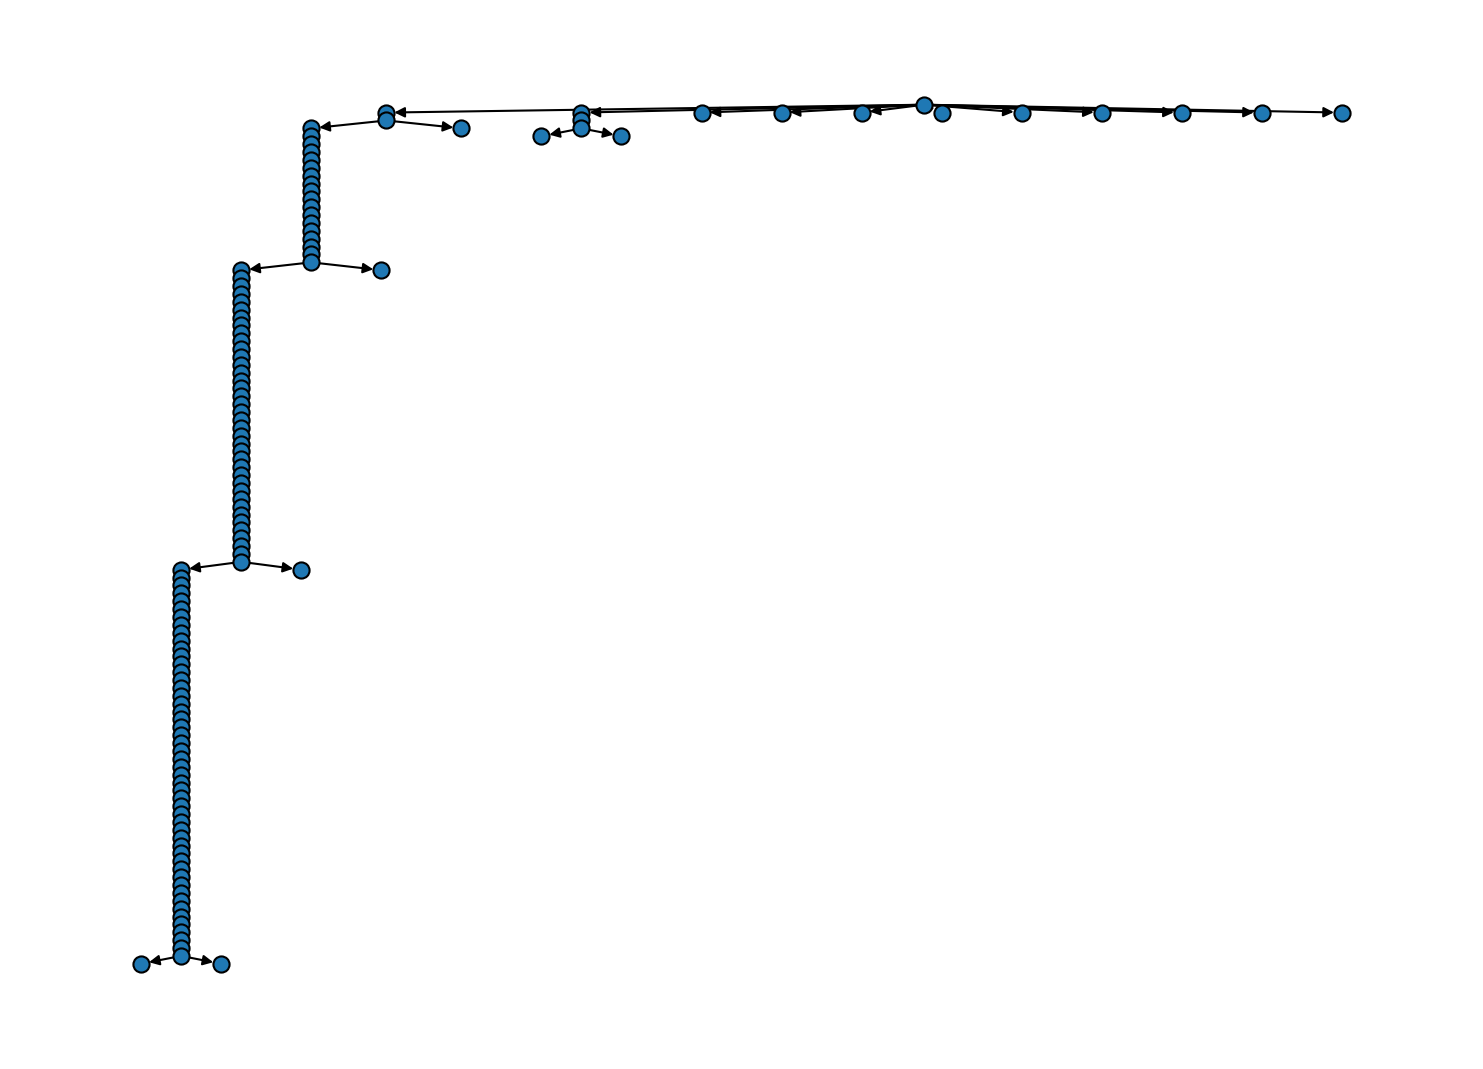

In [20]:
# Cluster hierarchy as tree diagram
#     (hierarchy level increasing from top to bottom)
fig, ax = plt.subplots(
    figsize=(
        mpl.rcParams["figure.figsize"][0] * 2.5,
        mpl.rcParams["figure.figsize"][1] * 3
    )
)
langerin_neighbourhoods.tree(
    ax=ax,
    draw_props={
        "node_size": 60,
        "node_shape": "o",
        "with_labels": False
    }
)

Another simplification is achieved through the `"lonechild"` protocol that will remove all the intermediate sole bundles at hierarchy levels where a cluster is only shrinking.

In [21]:
# Remove levels on which only one child appears
langerin_neighbourhoods.trim(langerin_neighbourhoods.root, protocol="lonechild")

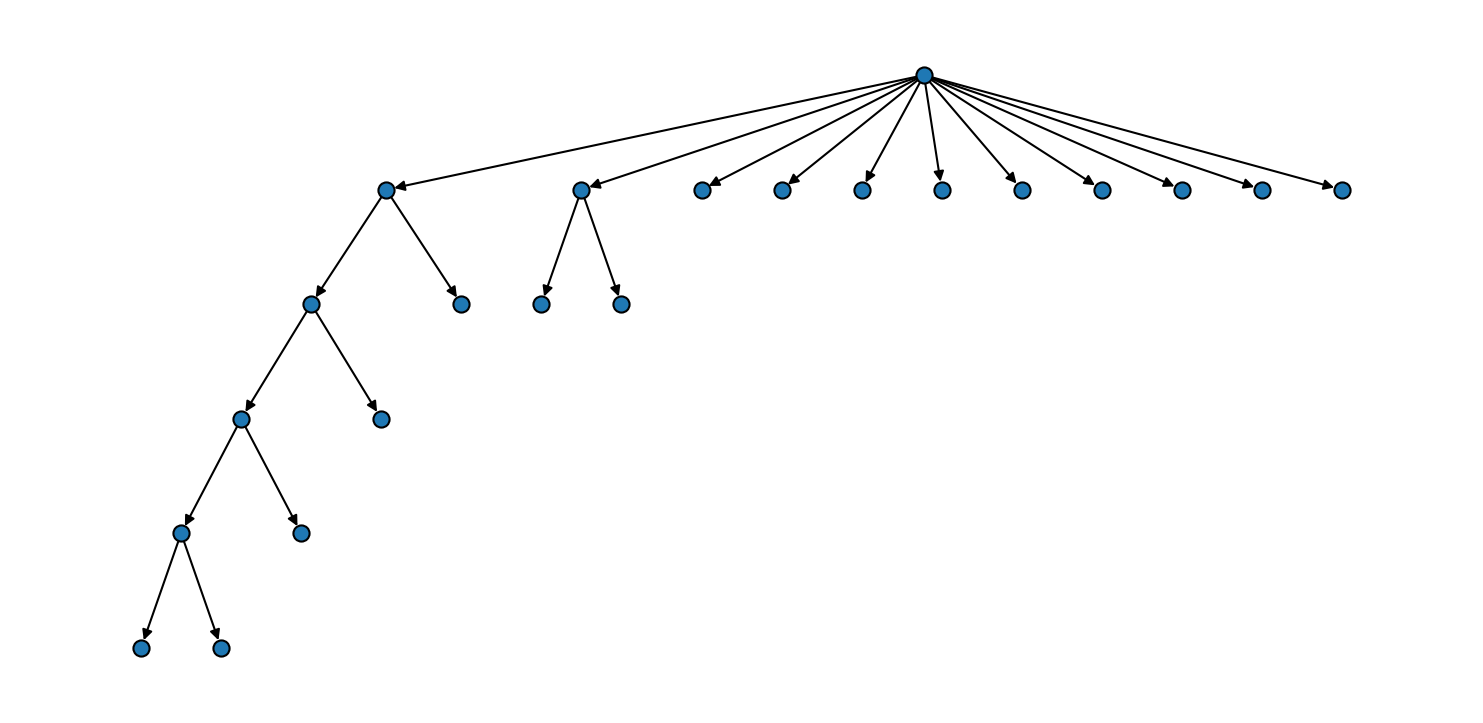

In [22]:
# Cluster hierarchy as tree diagram
#     (hierarchy level increasing from top to bottom)
fig, ax = plt.subplots(
    figsize=(
        mpl.rcParams["figure.figsize"][0] * 2.5,
        mpl.rcParams["figure.figsize"][1] * 2
    )
)
langerin_neighbourhoods.tree(
    ax=ax,
    draw_props={
        "node_size": 60,
        "node_shape": "o",
        "with_labels": False
    }
)

And we can finally put everything together and incorporate the child clusters into the root data set. Note that for this, the `"shrinking"` protocol would have been sufficient.

In [23]:
langerin_neighbourhoods.reel()

After this call, cluster labeling may not be contiguous and sorted by size, which we can fix easily, though.

In [24]:
langerin_neighbourhoods.root._labels.sort_by_size()

In [25]:
langerin.labels = langerin_neighbourhoods.labels[revert_order]

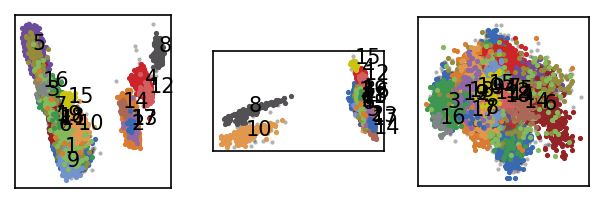

In [26]:
draw_evaluate(langerin)

(-0.3, 0.3)

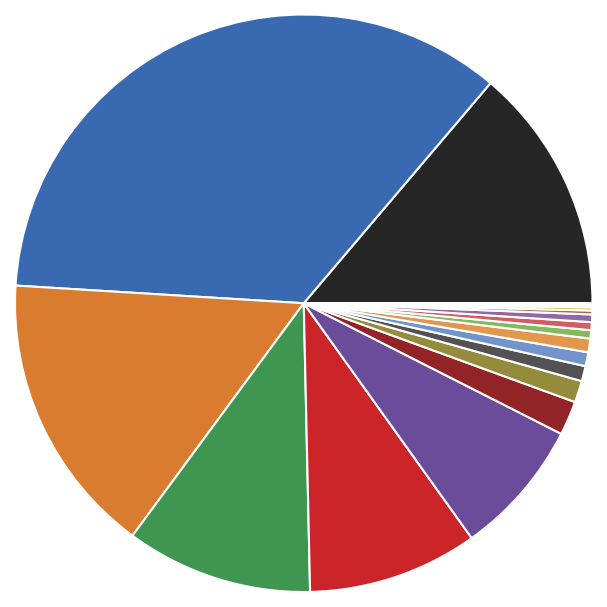

In [27]:
# Cluster hierarchy as pie diagram
#     (hierarchy level increasing from the center outwards)
_ = langerin.pie(
    pie_props={"normalize": True}
)
plt.xlim((-0.3, 0.3))
plt.ylim((-0.3, 0.3))

In [36]:
print("Label Size")
print("==========")
print(*(f"{l:>5} {s:>4}" for l, s in sorted({k: len(v) for k, v in langerin.root._labels.mapping.items()}.items())), sep="\n")

Label Size
    0 3661
    1 9344
    2 4210
    3 2774
    4 2528
    5 2029
    6  507
    7  322
    8  225
    9  207
   10  203
   11  123
   12  118
   13  113
   14   57
   15   46
   16   26
   17   16
   18   10
   19    9


For later re-use, we can remember the clustering parameters leading to the isolation of each cluster and save the cluster labels.

In [37]:
np.save("md_example/langerin_labels.npy", langerin.labels)

In [38]:
print("Label", "r", "n", sep="\t")
print("-" * 20)
for k, v in sorted(langerin_neighbourhoods.root._labels.meta["params"].items()):
    print(k, *v, sep="\t")

Label	r	n
--------------------
1	1.5	964
2	1.5	5
3	1.5	964
4	1.5	2
5	1.5	93
6	1.5	22
8	1.5	2
9	1.5	2
10	1.5	2
12	1.5	2
13	1.5	2
14	1.5	5
15	1.5	2
16	1.5	2
17	1.5	2
19	1.5	4
